# Team Interview Annotator (OpenAI) — Notebook

This notebook annotates interview transcripts and creates **augmented vectors** per ~250-token chunk:

`[embedding || normalized tag scores]` across 5 dimensions.

**What you get**

- Per-chunk **scores (0–3)** for each dimension
- A short **summary** per chunk
- **Embeddings** and **augmented vectors** (`embedding + normalized scores`)
- Saved outputs: `annotated_chunks.parquet`, `annotated_chunks.csv`, `augmented_vectors.npy`, and a slim `chunk_scores_only.csv`

**Before you run**

1. Install requirements in the next cell
2. Set your `OPENAI_API_KEY` or setup local LLM (Ollama) (env var)
3. Put your `.txt` transcripts in `./transcripts` (one interview per file)

In [1]:
# Install dependencies (uncomment if needed)
# %pip install -q openai>=1.40.0 tiktoken>=0.7.0 pandas>=2.0.0 pyarrow>=15.0.0 numpy>=1.24.0

# Environment & configuration

In [2]:
import os, re, glob, json, pathlib, typing, time
import numpy as np
import pandas as pd

# Expect OPENAI_API_KEY in your environment (or use a local OpenAI-compatible endpoint).

TRANSCRIPTS_DIR = os.environ.get("TRANSCRIPTS_DIR", "./data/transcripts")
OUT_DIR = os.environ.get("OUT_DIR", "./outputs")
BATCH_DIR = os.path.join(OUT_DIR, "batch_processing")
INPUT_JSONL = os.path.join(BATCH_DIR, "batch_input_all.jsonl")
NUM_BATCHES = 10
COMPLETION_WINDOW = "24h"
METADATA_DESCRIPTION = "Interview chunk annotation batch"
RESPONSES_MODEL = os.environ.get("OPENAI_MODEL_RESPONSES", "gpt-4o-mini")
EMBEDDING_MODEL = os.environ.get("OPENAI_MODEL_EMBEDDING", "text-embedding-3-large")
CHUNK_TOKENS = int(os.environ.get("CHUNK_TOKENS", 500))
CHUNK_OVERLAP = int(os.environ.get("CHUNK_OVERLAP", 250))
TOKENIZER_HINT = os.environ.get("TOKENIZER_HINT", "gpt-4o-mini")

os.makedirs(TRANSCRIPTS_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(BATCH_DIR, exist_ok=True)
os.makedirs(os.path.join(BATCH_DIR, "inputs"), exist_ok=True)
os.makedirs(os.path.join(BATCH_DIR, "outputs"), exist_ok=True)

print("TRANSCRIPTS_DIR:", TRANSCRIPTS_DIR)
print("OUT_DIR:", OUT_DIR)
print("BATCH_DIR:", BATCH_DIR)
print("RESPONSES_MODEL:", RESPONSES_MODEL)
print("EMBEDDING_MODEL:", EMBEDDING_MODEL)

TRANSCRIPTS_DIR: Research Module AI in Economics/Team/Interviews
OUT_DIR: Research Module AI in Economics/Team/Interviews/outputs
BATCH_DIR: Research Module AI in Economics/Team/Interviews/outputs/batch_processing
RESPONSES_MODEL: gpt-oss-20bn
EMBEDDING_MODEL: mxbai-embed-large:latest


## Find Transcripts

In [3]:
txt_files = sorted(glob.glob(os.path.join(TRANSCRIPTS_DIR, "**", "*.txt"), recursive=True))
print(f"Found {len(txt_files)} transcript(s)")

#create a data frame with file paths and file names and the content of the files
transcripts = []
for file_path in txt_files:
    with open(file_path, "r", encoding="utf-8") as f:
        content = f.read()
    transcripts.append({
        "file_path": file_path,
        "file_name": os.path.basename(file_path),
        "content": content
    })


transcripts = pd.DataFrame(transcripts)

Found 14 transcript(s)


## Chunking utilities (tiktoken optional)

In [3]:
try:
    import tiktoken
    _HAS_TIKTOKEN = True
except Exception:
    _HAS_TIKTOKEN = False

def get_tokenizer(model_hint: str = "gpt-4o"):
    if _HAS_TIKTOKEN:
        try:
            return tiktoken.encoding_for_model(model_hint)
        except Exception:
            return tiktoken.get_encoding("o200k_base")
    return None

def split_into_chunks(text: str, chunk_tokens: int, overlap: int, model_hint: str):
    enc = get_tokenizer(model_hint)
    if enc is not None:
        toks = enc.encode(text)
        chunks, start = [], 0
        while start < len(toks):
            end = min(start + chunk_tokens, len(toks))
            chunk = enc.decode(toks[start:end])
            chunks.append((start, end, chunk))
            if end == len(toks):
                break
            start = max(0, end - overlap)
        return chunks
    # Fallback: word-based approximation
    words = re.findall(r"\S+", text)
    approx_words = int(chunk_tokens * 0.75)
    overlap_words = int(overlap * 0.75)
    chunks, start = [], 0
    while start < len(words):
        end = min(start + approx_words, len(words))
        chunk = " ".join(words[start:end])
        chunks.append((start, end, chunk))
        if end == len(words):
            break
        start = max(0, end - overlap_words)
    return chunks

# Chunk document 

In [4]:
#chunk the transcripts into smaller pieces
all_chunks = []
for idx, row in transcripts.iterrows():
    file_id = row["file_name"]
    content = row["content"]
    chunks = split_into_chunks(content, CHUNK_TOKENS, CHUNK_OVERLAP, TOKENIZER_HINT)
    for chunk_start, chunk_end, chunk_text in chunks:
        all_chunks.append({
            "file_id": file_id,
            "chunk_start": chunk_start,
            "chunk_end": chunk_end,
            "chunk_text": chunk_text
        })      
all_chunks = pd.DataFrame(all_chunks)
print(f"Total chunks created: {len(all_chunks)}")

Total chunks created: 227


In [5]:
#print the first few chunks
all_chunks.head()

,file_id,chunk_start,chunk_end,chunk_text
0,103952_Member_1.txt,0,375,[Speaker_0] I'm good. [Speaker_0] Very cool. [...
1,103952_Member_1.txt,188,563,were asked to teach something for like 30 minu...
2,103952_Member_1.txt,376,751,"so you were like a tutor, personal tutor? [Spe..."
3,103952_Member_1.txt,564,939,"that I need to do it like, do it fast or do it..."
4,103952_Member_1.txt,752,1127,you might find annoying or weird or strange. [...


# Annotate the category of predominant type - classification

In [7]:
#use local LLM to annotate each chunk with predominant category type

"""
Classify a 20-min interview snippet into one of:
  - project_management | engineering_craft | creativity | technical_depth | marketing

Uses a local Ollama endpoint with the OpenAI-compatible client.
Model: gpt-oss:20b (must be available in your Ollama).
"""

from openai import OpenAI
import json
import sys

# --- Configure your local Ollama OpenAI endpoint ---
# Ollama exposes an OpenAI-compatible API at http://localhost:11434/v1
client = OpenAI(base_url="http://localhost:11434/v1", api_key="ollama")
MODEL = "gpt-oss:20b"

# --- Structured output schema (response_format) ---
JSON_SCHEMA = {
    "name": "SnippetClassification",
    "schema": {
        "type": "object",
        "properties": {
            "label": {
                "type": "string",
                "description": "Single label for the snippet",
                "enum": [
                    "project_management",
                    "engineering_craft",
                    "creativity",
                    "technical_depth",
                    "marketing"
                ]
            },
            "confidence": {
                "type": "number",
                "description": "Confidence 0.0–1.0",
                "minimum": 0,
                "maximum": 1
            },
            "rationale": {
                "type": "string",
                "description": "One or two short reasons based on the guiding questions"
            }
        },
        "required": ["label", "confidence", "rationale"],
        "additionalProperties": False
    },
    "strict": True
}

# --- Prompt (question-only cues + example questions drawn from your outline) ---
CLASSIFIER_SYSTEM = """You are a careful, fair, single-label snippet classifier.
Judge reasoning, not fluency; do not penalize grammar or accent.
Return only valid JSON that matches the provided schema."""

CLASSIFIER_USER_TEMPLATE = """You are classifying short interview snippets from 20-minute student interviews about applied projects.
Assign exactly one label:

1) project_management
2) engineering_craft
3) creativity
4) technical_depth
5) marketing

Category definitions as guiding questions (with example questions from the interview outline)

1) project_management
Guiding questions
- Is the speaker describing how they organize work to reach a result?
- Do they talk about choosing priorities or what not to do?
- Do they explain who does what, when, or how progress is tracked?
- Do they reflect on what changed or what they’d change next time?
Example interview questions
- “Tell me about a time you moved a project from idea to result. What was the result and how did you organize the work?”
- “How did you decide what not to do?”
- “Describe how you planned your week on that project.”
- “When a teammate was slower than expected, what did you do?”
- “How do you like to be updated, and how often do you update others?”
- Follow-ups: “What changed after your first plan?”, “How did you measure done?”, “What did you automate or template?”

2) engineering_craft
Guiding questions
- Is the speaker describing how they built or fixed something step by step?
- Do they say how they checked it works or when it’s “done”?
- Do they show care with details or focus while making or repairing?
- Are they describing a problem and how they narrowed it down?
Example interview questions
- “Walk me through a build you’re proud of—hardware, software, data, or lab. Where were the tricky details?”
- “How do you keep quality high under time pressure?”
- “Tell me about a bug or failure you chased. How did you isolate it?”
- “What’s your personal ‘definition of done’ for builds?”
- Follow-ups: “Why this structure?” “How did you test?”

3) creativity
Guiding questions
- Is the speaker proposing new ideas or several options for a problem?
- Are they combining ideas from different places?
- Do they suggest the smallest version to try first?
- Are they willing to drop an idea if it doesn’t work?
Example interview questions
- “Describe a time you combined two existing ideas into something new. What did you combine and why?”
- “When you get stuck, how do you generate options?”
- “What is a problem in daily life or your field that annoys you? Sketch three ways to solve it.”
- Follow-ups: “How would you prototype the smallest version?” “Who would be the first user?”

4) technical_depth
Guiding questions
- Is the speaker teaching or explaining a concept clearly?
- Do they point out assumptions, limits, or when it applies vs doesn’t?
- Are they showing they understand the idea beneath the method?
Example interview questions
- “What topic could you teach to others for 30 minutes with no slides? Outline your teaching plan.”
- “Tell me about a concept you changed your mind about after deeper study.”
- “What’s a frontier paper/tool you’ve tried to replicate? What worked and what didn’t?”
- Follow-ups: “Explain it to a high-school student.” “What are common failure modes?”

5) marketing
Guiding questions
- Is the speaker focused on who the first user/customer is?
- Do they discuss how to reach them or what message to use?
- Do they suggest how to test interest and what would count as success?
(Choose marketing only when at least one of the first two questions is clearly yes.)
Example interview questions
- “Tell me about a time you had to get attention for an idea or project. What was your message and channel?”
- “Who is the first paying user for our kind of project? What would persuade them?”
- “If you had €500 to test demand in 2 weeks, what would you do?”
- Follow-ups: “What’s your headline?” “What would you measure?”

Tie-break guide (as questions)
- Mainly about doing the work together and finishing? → project_management
- Mainly about how they made/fixed something? → engineering_craft
- Mainly about new options or first versions? → creativity
- Mainly about explaining ideas so others understand? → technical_depth
- Clearly about who to reach and how to reach them? → marketing

Output format (strict JSON)
Return only:
{{
  "label": "project_management | engineering_craft | creativity | technical_depth | marketing",
  "confidence": 0.0,
  "rationale": "<one or two short reasons based on the guiding questions above>"
}}

SNIPPET
\"\"\"{snippet}\"\"\""""

def classify_snippet(snippet: str) -> dict:
    """
    Sends the classification prompt to the local Ollama OpenAI endpoint.
    Tries JSON Schema response_format first; if unsupported, falls back to instruction-only JSON.
    """
    # Attempt with response_format JSON schema (some OpenAI-compatible servers support this)
    try:
        resp = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": CLASSIFIER_SYSTEM},
                {"role": "user", "content": CLASSIFIER_USER_TEMPLATE.format(snippet=snippet)}
            ],
            temperature=0.0,
            # Some OpenAI-compatible servers accept this; Ollama may ignore it, hence the try/except
            response_format={
                "type": "json_schema",
                "json_schema": JSON_SCHEMA,
            },
        )
        content = resp.choices[0].message.content
        return json.loads(content)
    except Exception:
        # Fallback: ask for JSON explicitly and parse
        resp = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": CLASSIFIER_SYSTEM + " You must return ONLY valid JSON."},
                {"role": "user", "content": CLASSIFIER_USER_TEMPLATE.format(snippet=snippet)}
            ],
            temperature=0.0,
        )
        content = resp.choices[0].message.content.strip()
        # Try to parse; if the model included extra text, extract the first JSON object
        try:
            return json.loads(content)
        except Exception:
            import re
            m = re.search(r"\{.*\}", content, re.S)
            if not m:
                raise RuntimeError(f"Model did not return JSON. Raw:\n{content}")
            return json.loads(m.group(0))


In [9]:
#classify first snippet
# all_chunks.head()
snippet_text = all_chunks.iloc[0]["chunk_text"]

result = classify_snippet(snippet_text)
print(json.dumps(result, ensure_ascii=False, indent=2))



{
  "label": "technical_depth",
  "confidence": 0.95,
  "rationale": "Speaker outlines how to teach a math concept, focusing on explaining steps and structure."
}


In [10]:
#process all chunks and attach the label to the chunk data frame
labels = []
for idx, row in all_chunks.iterrows():
    chunk_text = row["chunk_text"]
    result = classify_snippet(chunk_text)
    labels.append(result)
all_chunks["annotation"] = labels



In [ ]:
# Extract label/confidence once and compute label counts
all_chunks["label"] = all_chunks["annotation"].apply(lambda x: x["label"])
all_chunks["confidence"] = all_chunks["annotation"].apply(lambda x: x["confidence"])

label_counts = all_chunks.groupby(["file_id", "label"]).size().unstack(fill_value=0)

# Optional merged buckets
label_counts["technical_expertise"] = label_counts.get("technical_depth", 0) + label_counts.get("engineering_craft", 0)
label_counts = label_counts.drop(columns=["technical_depth", "engineering_craft"], errors='ignore')
label_counts["creativity_marketing"] = label_counts.get("creativity", 0) + label_counts.get("marketing", 0)
label_counts = label_counts.drop(columns=["creativity", "marketing"], errors='ignore')

label_counts

In [30]:
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# Optional: still normalize any Period columns, just in case
for col in all_chunks.columns:
    if isinstance(all_chunks[col].dtype, pd.PeriodDtype):
        all_chunks[col] = all_chunks[col].dt.to_timestamp()

# make sure OUT_DIR exists
os.makedirs(OUT_DIR, exist_ok=True)

out_file = os.path.join(OUT_DIR, "annotated_chunks.parquet")

# Convert DataFrame -> Arrow table and write with pyarrow
table = pa.Table.from_pandas(all_chunks, preserve_index=False)
pq.write_table(table, out_file)

print(f"Saved annotated chunks to {out_file}")


Saved annotated chunks to Research Module AI in Economics/Team/Interviews/outputs/annotated_chunks.parquet


In [ ]:
#read annotated_chunks.parquet
annotated_chunks = pd.read_parquet(os.path.join(OUT_DIR, "annotated_chunks.parquet"))
annotated_chunks.head()

In [5]:
#print column names of all_chunks
print(annotated_chunks.columns)

Index(['file_id', 'chunk_start', 'chunk_end', 'chunk_text', 'annotation',
       'label', 'confidence', 'embedding'],
      dtype='object')


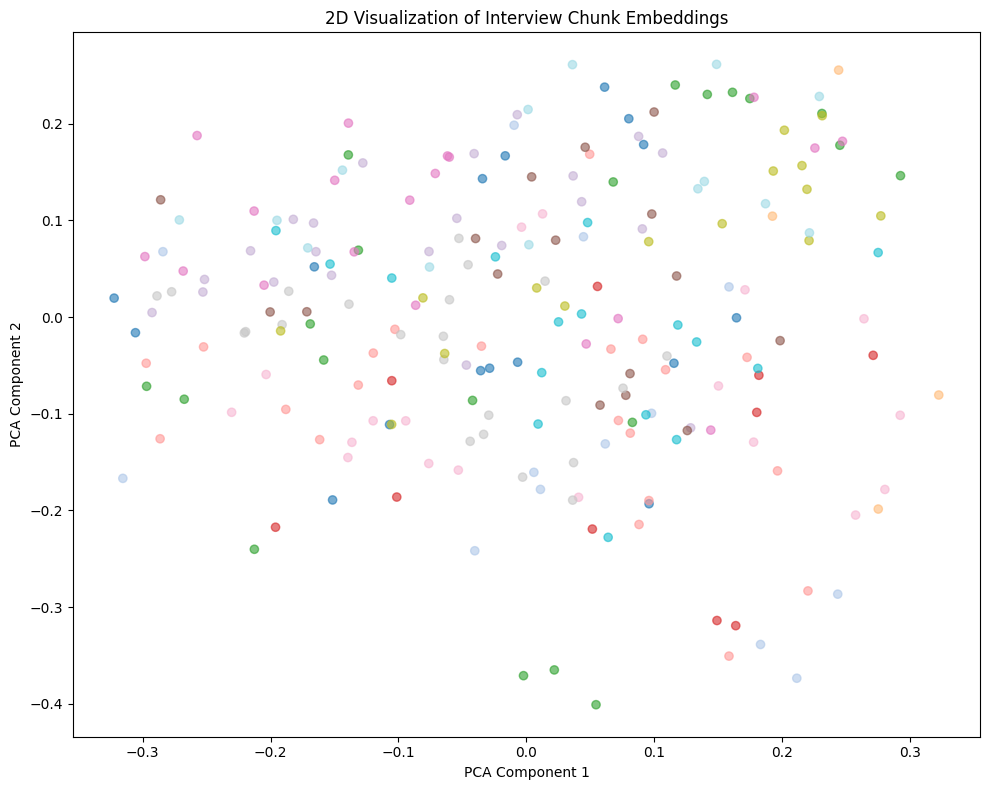

In [6]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Build a stable color mapping from file -> color
files = annotated_chunks['file_id'].astype(str)
unique_files = sorted(files.unique())
cmap = plt.get_cmap('tab20', len(unique_files))  # discrete palette
file_to_color = {f: cmap(i) for i, f in enumerate(unique_files)}

# Convert list of embeddings to a 2D array
embeddings_array = np.vstack(annotated_chunks['embedding'].values)

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_array)

# Plot the reduced embeddings (no legend / colorbar)
plt.figure(figsize=(10, 8))
plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=files.map(file_to_color),
    alpha=0.6,
)
plt.title('2D Visualization of Interview Chunk Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout()
plt.show()




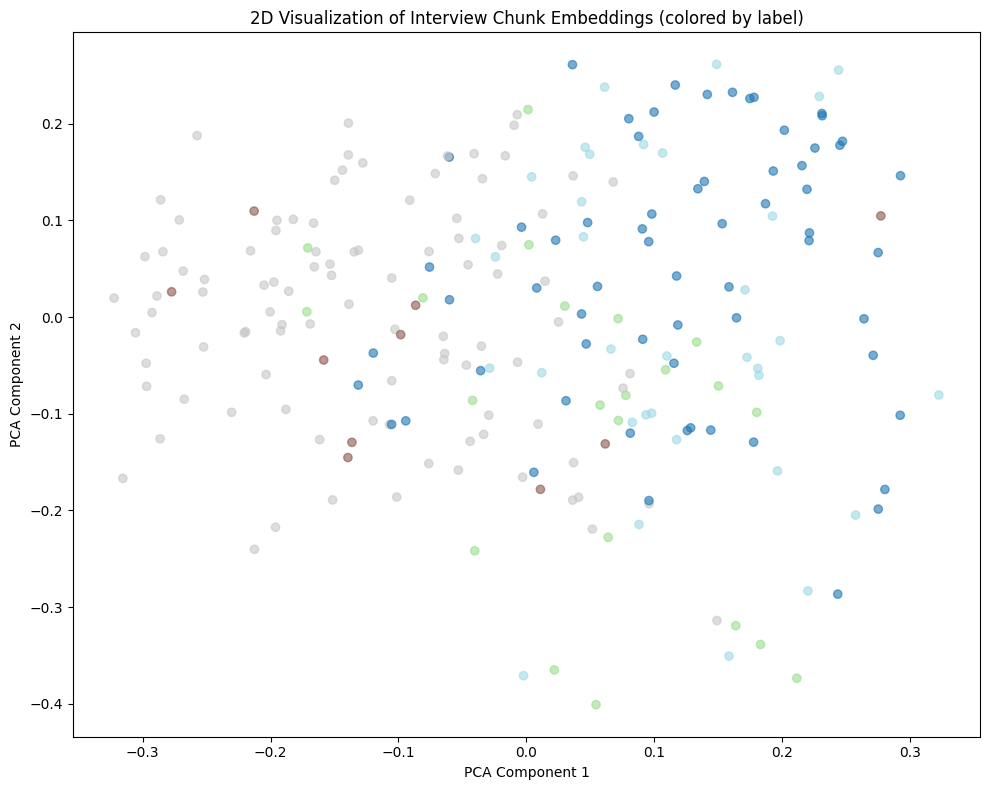

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1. Get labels as strings
labels = annotated_chunks['label'].astype(str)
unique_labels = sorted(labels.unique())

# 2. Build a stable color mapping from label -> color
cmap = plt.get_cmap("tab20")  # or 'tab10' if you have <=10 labels
label_to_color = {
    lab: cmap(i / max(1, len(unique_labels) - 1))
    for i, lab in enumerate(unique_labels)
}

point_colors = labels.map(label_to_color)

# 3. Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_array)

# 4. Plot the reduced embeddings, colored by label
plt.figure(figsize=(10, 8))
plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=point_colors,
    alpha=0.6,
)
plt.title('2D Visualization of Interview Chunk Embeddings (colored by label)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout()
plt.show()


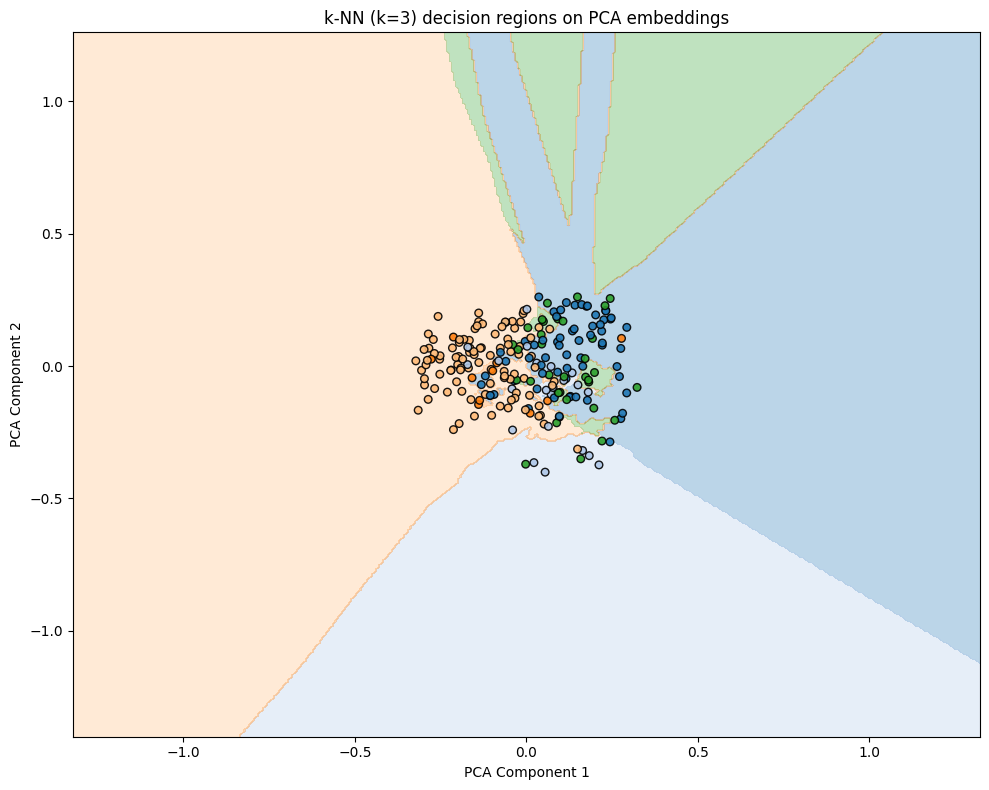

In [8]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap

# Map labels -> integer classes for KNN and plotting
unique_labels = np.array(sorted(labels.unique()))
label_to_idx = {lab: i for i, lab in enumerate(unique_labels)}
y = labels.map(label_to_idx).to_numpy()

# Fit k-NN classifier in PCA space
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(reduced_embeddings, y)

# Create a grid over the PCA space
x_min, x_max = reduced_embeddings[:, 0].min() - 1, reduced_embeddings[:, 0].max() + 1
y_min, y_max = reduced_embeddings[:, 1].min() - 1, reduced_embeddings[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400),
)

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = knn.predict(grid_points)
Z = Z.reshape(xx.shape)

# Build a colormap (one color per label)
cmap = ListedColormap(plt.get_cmap("tab20").colors[:len(unique_labels)])

plt.figure(figsize=(10, 8))

# Filled decision regions
plt.contourf(
    xx,
    yy,
    Z,
    alpha=0.3,
    cmap=cmap,
    levels=np.arange(len(unique_labels) + 1) - 0.5,
)

# Overlay the actual points
plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=y,
    cmap=cmap,
    edgecolor="k",
    s=30,
    alpha=0.9,
)

plt.title("k-NN (k=3) decision regions on PCA embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


# Turning unit into a speaker/label

In [ ]:
import numpy as np
import pandas as pd

# Average embeddings within each (file_id, label) group
def avg_embedding(emb_series: pd.Series):
    # assumes each entry is a 1D array / list of floats
    arrs = np.stack(emb_series.to_numpy())
    return arrs.mean(axis=0)

# Group by (file_id, label) to get ONE row per combination
docs = (
    annotated_chunks
    .groupby(['file_id', 'label'], as_index=False)
    .agg(
        chunk_start=('chunk_start', 'min'),             # earliest chunk
        chunk_end=('chunk_end', 'max'),                 # latest chunk
        chunk_text=('chunk_text', 
                    lambda x: "\n\n".join(x.astype(str))),  # concat text
        # keep all annotations as a list (dicts are fine here)
        annotation=('annotation', lambda x: list(x)),
        confidence=('confidence', 'mean'),              # avg confidence
        embedding=('embedding', avg_embedding)          # doc-level embedding
    )
)

print(docs)

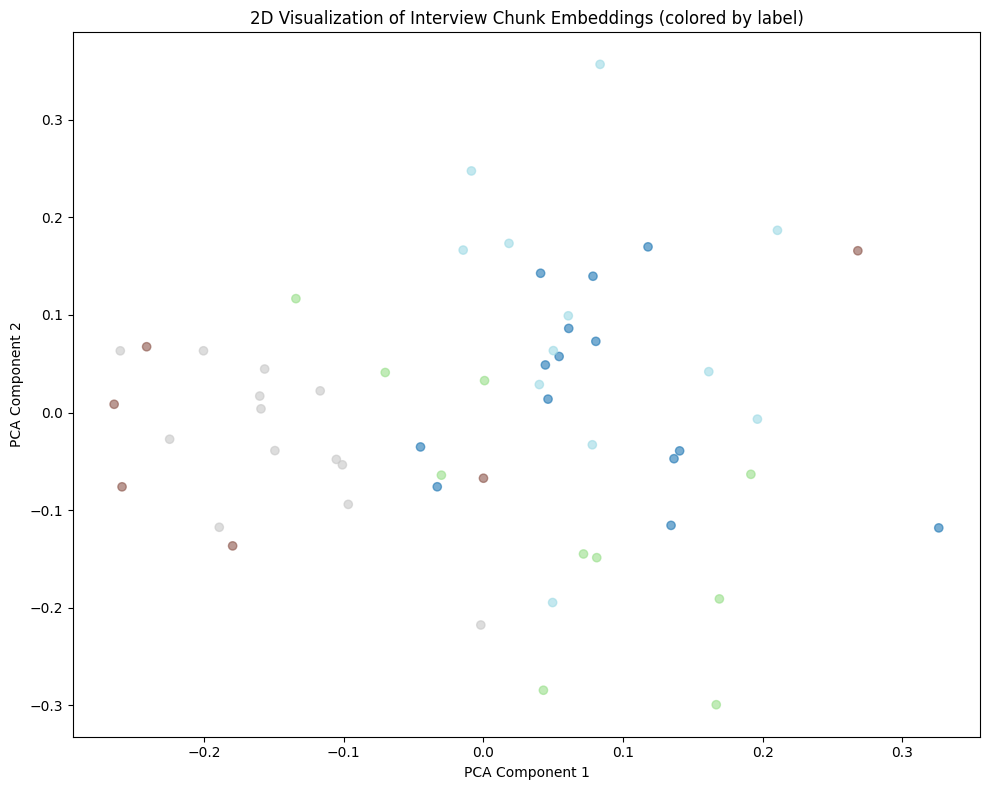

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

embeddings_array = np.vstack(docs['embedding'].values)

# 1. Get labels as strings
labels = docs['label'].astype(str)
unique_labels = sorted(labels.unique())

# 2. Build a stable color mapping from label -> color
cmap = plt.get_cmap("tab20")  # or 'tab10' if you have <=10 labels
label_to_color = {
    lab: cmap(i / max(1, len(unique_labels) - 1))
    for i, lab in enumerate(unique_labels)
}

point_colors = labels.map(label_to_color)

# 3. Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_array)

# 4. Plot the reduced embeddings, colored by label
plt.figure(figsize=(10, 8))
plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=point_colors,
    alpha=0.6,
)
plt.title('2D Visualization of Interview Chunk Embeddings (colored by label)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout()
plt.show()


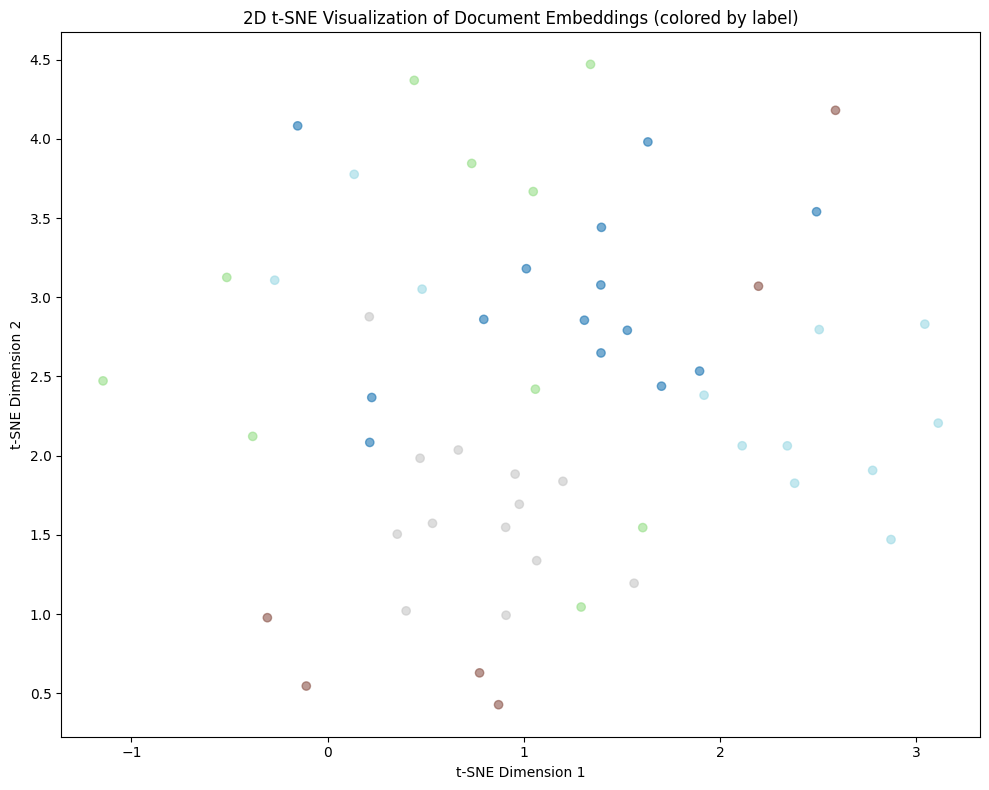

In [7]:
#instead of PCA use tSNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Stack embeddings into a 2D array (n_docs x dim)
embeddings_array = np.vstack(docs['embedding'].values)

# 1. Get labels as strings
labels = docs['label'].astype(str)
unique_labels = sorted(labels.unique())

# 2. Build a stable color mapping from label -> color
cmap = plt.get_cmap("tab20")  # or 'tab10' if you have <=10 labels
label_to_color = {
    lab: cmap(i / max(1, len(unique_labels) - 1))
    for i, lab in enumerate(unique_labels)
}
point_colors = labels.map(label_to_color)

# 3. Reduce dimensions to 2D using t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=30,          # tweak based on dataset size (e.g. 5–50)
    learning_rate='auto',
    init='pca',             # good default for high-dimensional data
    random_state=42,
)
reduced_embeddings = tsne.fit_transform(embeddings_array)

# 4. Plot the reduced embeddings, colored by label
plt.figure(figsize=(10, 8))
plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=point_colors,
    alpha=0.6,
)
plt.title('2D t-SNE Visualization of Document Embeddings (colored by label)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()


# Do now the combinatorical optimization

In [8]:
from itertools import combinations

def generate_partitions_4_4_3_3(file_ids):
    """
    Yield all partitions of `file_ids` into 4 disjoint groups:
    two of size 4 and two of size 3.
    
    Each partition is yielded as a tuple: (group4a, group4b, group3a, group3b),
    where each group is a tuple of file_ids.
    
    Groups of the same size are treated as unlabelled via ordering constraints,
    so each partition appears exactly once.
    """
    file_ids = list(file_ids)
    assert len(file_ids) == 14, "This function assumes exactly 14 file_ids."
    
    for g4_1 in combinations(file_ids, 4):
        remaining1 = [x for x in file_ids if x not in g4_1]
        
        for g4_2 in combinations(remaining1, 4):
            # Avoid double-counting pairs of size-4 groups:
            # only keep order where min(g4_1) <= min(g4_2)
            if min(g4_2) < min(g4_1):
                continue
            
            remaining2 = [x for x in remaining1 if x not in g4_2]
            
            for g3_1 in combinations(remaining2, 3):
                g3_2 = tuple(x for x in remaining2 if x not in g3_1)
                # Avoid double-counting pairs of size-3 groups
                if min(g3_2) < min(g3_1):
                    continue
                
                yield (tuple(g4_1), tuple(g4_2), tuple(g3_1), tuple(g3_2))


In [10]:
file_ids = sorted(docs['file_id'].unique())
len(file_ids)  # should be 14

# Quick sanity-check: count how many partitions there are
count = sum(1 for _ in generate_partitions_4_4_3_3(file_ids))
print("Number of partitions:", count)  # should be 1,051,050


Number of partitions: 1051050


In [ ]:
#give some sample assignments
partitions = list(generate_partitions_4_4_3_3(file_ids))
sample_partition = partitions[0]
print("Sample partition (4-4-3-3):", sample_partition)  

In [12]:
import numpy as np
import pandas as pd

# Make sure labels are strings
docs['label'] = docs['label'].astype(str)

labels = sorted(docs['label'].unique())
assert len(labels) == 5, f"Expected 5 labels (concept dimensions), got {len(labels)}"

def compute_label_entropy(df, file_col='file_id', label_col='label'):
    labels = sorted(df[label_col].astype(str).unique())
    denom = np.log(max(len(labels), 1))
    entropy_by_file = {}
    for file_id, sub in df.groupby(file_col):
        counts = sub[label_col].value_counts().reindex(labels, fill_value=0).to_numpy()
        total = counts.sum()
        if total == 0:
            entropy_by_file[file_id] = 0.0
            continue
        p = counts / total
        p = p[p > 0]
        ent = -float(np.sum(p * np.log(p)))
        ent_norm = ent / denom if denom > 0 else 0.0
        entropy_by_file[file_id] = ent_norm
    return entropy_by_file

label_entropy_by_file = compute_label_entropy(annotated_chunks)
print(f"Computed label entropy for {len(label_entropy_by_file)} participants.")

def compute_concept_vectors(docs, labels, label_col='label', emb_col='embedding', alpha=1.0):
    """Compute smoothed concept vectors with an add-one prior to reduce brittleness."""
    concept_vecs = {}
    stats = {}

    all_embs = np.stack(docs[emb_col].to_numpy()).astype(float)
    prior = all_embs.mean(axis=0)
    prior_norm = np.linalg.norm(prior)
    if prior_norm > 0:
        prior = prior / prior_norm

    for lab in labels:
        emb_list = docs.loc[docs[label_col] == lab, emb_col].to_numpy()
        if len(emb_list) == 0:
            mean_vec = np.zeros_like(prior)
            var_mean = 1.0
        else:
            arr = np.stack(emb_list).astype(float)
            mean_vec = arr.mean(axis=0)
            var_mean = float(arr.var(axis=0).mean())

        smooth_vec = (mean_vec * len(emb_list) + alpha * prior) / (len(emb_list) + alpha)
        norm = np.linalg.norm(smooth_vec)
        if norm > 0:
            smooth_vec = smooth_vec / norm

        concept_vecs[lab] = smooth_vec
        stats[lab] = {
            "count": int(len(emb_list)),
            "variance_mean": var_mean,
            "reliability_weight": (len(emb_list) / (len(emb_list) + alpha)) * (1.0 / (1.0 + var_mean)),
        }

    meta = {"prior": prior, "alpha": alpha, "stats": stats}
    return concept_vecs, meta

concept_vecs, concept_meta = compute_concept_vectors(docs, labels, alpha=1.0)
emb_dim = concept_vecs[labels[0]].shape[0]
print("Embedding dimension:", emb_dim)
print("Concept prior alpha:", concept_meta["alpha"])


Computed label entropy for 14 participants.
Embedding dimension: 1024
Concept prior alpha: 1.0


In [ ]:
import numpy as np
import pandas as pd

# Make sure labels are strings
docs['label'] = docs['label'].astype(str)

labels = sorted(docs['label'].unique())
assert len(labels) == 5, f"Expected 5 labels (concept dimensions), got {len(labels)}"

def compute_label_entropy(df, file_col='file_id', label_col='label'):
    labels = sorted(df[label_col].astype(str).unique())
    denom = np.log(max(len(labels), 1))
    entropy_by_file = {}
    for file_id, sub in df.groupby(file_col):
        counts = sub[label_col].value_counts().reindex(labels, fill_value=0).to_numpy()
        total = counts.sum()
        if total == 0:
            entropy_by_file[file_id] = 0.0
            continue
        p = counts / total
        p = p[p > 0]
        ent = -float(np.sum(p * np.log(p)))
        ent_norm = ent / denom if denom > 0 else 0.0
        entropy_by_file[file_id] = ent_norm
    return entropy_by_file

label_entropy_by_file = compute_label_entropy(annotated_chunks)
print(f"Computed label entropy for {len(label_entropy_by_file)} participants.")

def compute_concept_vectors(docs, labels, label_col='label', emb_col='embedding', alpha=1.0):
    """Compute smoothed concept vectors with an add-one prior to reduce brittleness."""
    concept_vecs = {}
    stats = {}

    all_embs = np.stack(docs[emb_col].to_numpy()).astype(float)
    prior = all_embs.mean(axis=0)
    prior_norm = np.linalg.norm(prior)
    if prior_norm > 0:
        prior = prior / prior_norm

    for lab in labels:
        emb_list = docs.loc[docs[label_col] == lab, emb_col].to_numpy()
        if len(emb_list) == 0:
            mean_vec = np.zeros_like(prior)
            var_mean = 1.0
        else:
            arr = np.stack(emb_list).astype(float)
            mean_vec = arr.mean(axis=0)
            var_mean = float(arr.var(axis=0).mean())

        smooth_vec = (mean_vec * len(emb_list) + alpha * prior) / (len(emb_list) + alpha)
        norm = np.linalg.norm(smooth_vec)
        if norm > 0:
            smooth_vec = smooth_vec / norm

        concept_vecs[lab] = smooth_vec
        stats[lab] = {
            "count": int(len(emb_list)),
            "variance_mean": var_mean,
            "reliability_weight": (len(emb_list) / (len(emb_list) + alpha)) * (1.0 / (1.0 + var_mean)),
        }

    meta = {"prior": prior, "alpha": alpha, "stats": stats}
    return concept_vecs, meta

concept_vecs, concept_meta = compute_concept_vectors(docs, labels, alpha=1.0)
emb_dim = concept_vecs[labels[0]].shape[0]
print("Embedding dimension:", emb_dim)
print("Concept prior alpha:", concept_meta["alpha"])


import numpy as np

def group_concept_coverage(docs, group_file_ids, labels, concept_vecs, concept_meta,
                           label_entropy_by_file=None, alpha=1.0, softmin_tau=0.15,
                           file_col='file_id', label_col='label', emb_col='embedding'):
    """
    Return:
      - group_score: combined weighted score (0.5*min + 0.5*mean) using smoothed vectors
      - metrics: raw/weighted breakdown, entropy factor, per-label details
    """
    subset = docs[docs[file_col].isin(group_file_ids)]
    per_label_raw = {}
    per_label_weighted = {}
    label_details = {}
    prior = concept_meta.get("prior", None)
    alpha = concept_meta.get("alpha", alpha)

    for lab in labels:
        sub_lab = subset[subset[label_col] == lab]
        emb_list = sub_lab[emb_col].to_numpy()
        count = len(emb_list)

        if count > 0:
            arr = np.stack(emb_list).astype(float)
            mean_vec = arr.mean(axis=0)
            var_mean = float(arr.var(axis=0).mean())
        else:
            mean_vec = np.zeros_like(prior)
            var_mean = 1.0

        smooth_vec = (mean_vec * count + alpha * prior) / (count + alpha)
        norm = np.linalg.norm(smooth_vec)
        if norm > 0:
            smooth_vec = smooth_vec / norm

        cos_sim = float(np.dot(smooth_vec, concept_vecs[lab]))
        cos_sim = max(cos_sim, 0.0)

        reliability = (count / (count + alpha)) * (1.0 / (1.0 + var_mean))
        weighted_score = cos_sim * reliability

        per_label_raw[lab] = cos_sim
        per_label_weighted[lab] = weighted_score
        label_details[lab] = {
            "count": int(count),
            "variance_mean": var_mean,
            "raw_cosine": cos_sim,
            "reliability_weight": reliability,
            "weighted_score": weighted_score,
        }

    raw_vals = list(per_label_raw.values()) or [0.0]
    weighted_vals = list(per_label_weighted.values()) or [0.0]

    def softmin(vals, tau):
        vals = np.array(vals, dtype=float)
        return float(-tau * np.log(np.mean(np.exp(-vals / max(tau, 1e-6)))))

    raw_min, raw_mean = min(raw_vals), float(np.mean(raw_vals))
    raw_softmin = softmin(raw_vals, softmin_tau)
    raw_combined = 0.5 * raw_min + 0.5 * raw_mean

    w_min, w_mean = min(weighted_vals), float(np.mean(weighted_vals))
    w_softmin = softmin(weighted_vals, softmin_tau)
    w_combined = 0.5 * w_min + 0.5 * w_mean

    entropy_stats = {}
    if label_entropy_by_file:
        entropies = [label_entropy_by_file.get(fid, 0.0) for fid in group_file_ids]
        entropy_stats = {
            "mean_entropy": float(np.mean(entropies)),
            "min_entropy": float(np.min(entropies)),
        }
    entropy_factor = 1.0
    if entropy_stats:
        entropy_factor = 0.5 + 0.5 * entropy_stats["mean_entropy"]
    entropy_adjusted = w_combined * entropy_factor

    metrics = {
        "raw": {
            "min": raw_min,
            "mean": raw_mean,
            "softmin": raw_softmin,
            "combined": raw_combined,
        },
        "weighted": {
            "min": w_min,
            "mean": w_mean,
            "softmin": w_softmin,
            "combined": w_combined,
        },
        "entropy_factor": entropy_factor,
        "entropy_adjusted_score": entropy_adjusted,
        "per_label": label_details,
    }

    group_score = w_combined
    return group_score, metrics


In [14]:
from itertools import combinations

def generate_partitions_4_4_3_3(file_ids):
    """
    Yield all partitions of 14 file_ids into 4 disjoint groups:
      two of size 4 and two of size 3.

    Each partition: (group4a, group4b, group3a, group3b)
    Groups of same size treated as unlabelled (no duplicates).
    """
    file_ids = list(file_ids)
    assert len(file_ids) == 14, "This generator assumes exactly 14 file_ids."

    for g4_1 in combinations(file_ids, 4):
        remaining1 = [x for x in file_ids if x not in g4_1]

        for g4_2 in combinations(remaining1, 4):
            # Avoid double-counting (unordered pair of 4-groups)
            if min(g4_2) < min(g4_1):
                continue

            remaining2 = [x for x in remaining1 if x not in g4_2]

            for g3_1 in combinations(remaining2, 3):
                g3_2 = tuple(x for x in remaining2 if x not in g3_1)
                # Avoid double-counting (unordered pair of 3-groups)
                if min(g3_2) < min(g3_1):
                    continue

                yield (tuple(g4_1), tuple(g4_2), tuple(g3_1), tuple(g3_2))

def score_assignment(groups, docs, labels, concept_vecs, concept_meta,
                     label_entropy_by_file=None, alpha=1.0, softmin_tau=0.15):
    """
    groups: (g4a, g4b, g3a, g3b), each a tuple of file_ids
    returns:
      overall_score: min over the four group_scores (weighted combined)
      group_scores: list of 4 group_scores
      per_group_metrics: list of dicts (one per group)
      overall_entropy_adjusted: min of entropy-adjusted scores
      overall_softmin: min soft-min score across groups
    """
    group_scores = []
    per_group_metrics = []

    for group_file_ids in groups:
        g_score, metrics = group_concept_coverage(
            docs,
            group_file_ids,
            labels,
            concept_vecs,
            concept_meta,
            label_entropy_by_file=label_entropy_by_file,
            alpha=alpha,
            softmin_tau=softmin_tau,
        )
        group_scores.append(g_score)
        per_group_metrics.append(metrics)

    overall_score = min(group_scores) if group_scores else 0.0
    overall_entropy_adjusted = min(m["entropy_adjusted_score"] for m in per_group_metrics) if per_group_metrics else 0.0
    overall_softmin = min(m["weighted"]["softmin"] for m in per_group_metrics) if per_group_metrics else 0.0
    return overall_score, group_scores, per_group_metrics, overall_entropy_adjusted, overall_softmin


In [28]:
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor  # <-- threads instead of processes
import multiprocessing as mp

# -------------------------------------------------
# 0. Worker scoring function (no initializer needed)
# -------------------------------------------------

def score_single_partition(args):
    """
    Score a single (sample_id, groups) pair in a worker thread.
    Uses `docs`, `labels`, `concept_vecs` from the outer scope.
    """
    sample_id, groups = args

    (overall,
     group_scores,
     per_group_metrics,
     overall_entropy_adjusted,
     overall_softmin) = score_assignment(
        groups,
        docs,
        labels,
        concept_vecs,
        concept_meta,
        label_entropy_by_file=label_entropy_by_file,
    )

    g4a, g4b, g3a, g3b = groups

    return {
        "sample_id": sample_id,
        "overall_score": overall,
        "overall_entropy_adjusted": overall_entropy_adjusted,
        "overall_softmin": overall_softmin,
        "g4a_score": group_scores[0],
        "g4b_score": group_scores[1],
        "g3a_score": group_scores[2],
        "g3b_score": group_scores[3],
        "g4a": g4a,
        "g4b": g4b,
        "g3a": g3a,
        "g3b": g3b,
        "per_group_metrics": per_group_metrics,
    }

# -------------------------------------------------
# 1. Generate sampled partitions
# -------------------------------------------------

N = 1_051_050   # number of 4-4-3-3 partitions of 14 elements
n_samples = 500000
rng = np.random.default_rng(42)

sample_idx = set(rng.choice(N, size=n_samples, replace=False))

sample_partitions = []
for i, partition in enumerate(generate_partitions_4_4_3_3(file_ids)):
    if i in sample_idx:
        sample_partitions.append(partition)

# -------------------------------------------------
# 2. Score ALL sampled partitions in parallel (threads)
# -------------------------------------------------

# Prepare iterable of (sample_id, groups) pairs
tasks = list(enumerate(sample_partitions))

# Choose number of workers (you can tune this)
n_workers = min(32, mp.cpu_count())  # avoid oversubscribing

with ThreadPoolExecutor(max_workers=n_workers) as executor:
    # executor.map preserves order, so sample_id alignment is maintained
    records = list(executor.map(score_single_partition, tasks))

scores_df = pd.DataFrame(records)


# Now plot the distributions of the scores

<Axes: title={'center': 'Distribution of Overall Group Concept Coverage Scores'}, xlabel='Overall Group Concept Coverage Score', ylabel='Frequency'>

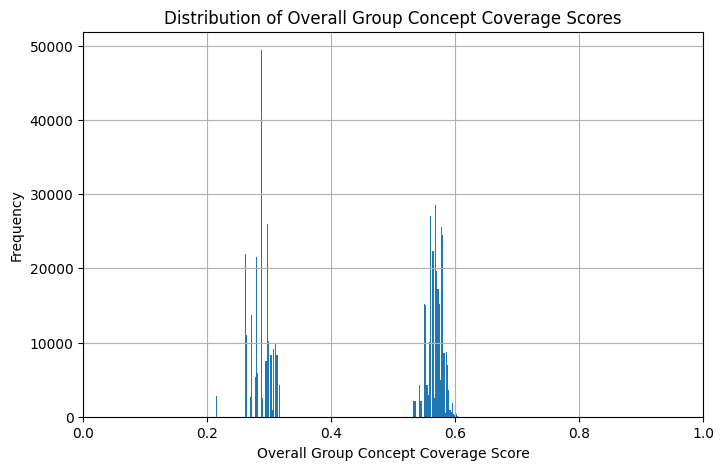

In [29]:
# Distribution of the main measure across sampled allocations
scores_df['overall_score'].describe()

# Quick histogram - start histogram at 0.5
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.xlim(0.0, 1.0)
plt.xlabel('Overall Group Concept Coverage Score')
plt.ylabel('Frequency')
plt.title('Distribution of Overall Group Concept Coverage Scores')
scores_df['overall_score'].hist(bins=200)


In [30]:
import numpy as np
import matplotlib.pyplot as plt

def polygon_area(vals):
    vals = np.array(vals, dtype=float)
    n = len(vals)
    if n == 0:
        return 0.0, 0.0
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    x = vals * np.cos(angles)
    y = vals * np.sin(angles)
    area = 0.5 * np.abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))
    full_area = 0.5 * n * np.sin(2 * np.pi / n)
    return float(area), float(area / full_area if full_area > 0 else 0.0)

def plot_radar(label_order, scores, title="", color='tab:blue'):
    n = len(label_order)
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    vals = np.array([scores.get(lab, 0.0) for lab in label_order], dtype=float)
    vals = np.clip(vals, 0, 1)
    # close the loop
    angles = np.concatenate([angles, angles[:1]])
    vals = np.concatenate([vals, vals[:1]])

    fig, ax = plt.subplots(subplot_kw={'polar': True}, figsize=(5, 5))
    ax.plot(angles, vals, color=color, linewidth=2)
    ax.fill(angles, vals, color=color, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(label_order)
    ax.set_ylim(0, 1)
    ax.set_title(title)
    return fig, ax


In [ ]:
# Min–max rescale radar dimensions (per-label weighted scores) to [0,1] across partitions
import numpy as np
import pandas as pd

label_order = labels  # keep the consistent order used elsewhere

def extract_partition_scores(row):
    """Mean per-label weighted score across the 4 groups for one partition."""
    per_label_vals = {lab: [] for lab in label_order}
    for metrics in row["per_group_metrics"]:
        per_label = metrics["per_label"]
        for lab in label_order:
            per_label_vals[lab].append(per_label.get(lab, {}).get("weighted_score", 0.0))
    return np.array([np.mean(per_label_vals[lab]) for lab in label_order])

# Matrix: rows = partitions, cols = labels
label_scores = np.vstack(scores_df.apply(extract_partition_scores, axis=1))

mins = label_scores.min(axis=0)
maxs = label_scores.max(axis=0)
denom = np.where(maxs > mins, maxs - mins, 1.0)
label_scores_norm = (label_scores - mins) / denom
label_scores_norm = np.clip(label_scores_norm, 0, 1)

# Optional: store normalized per-label scores alongside scores_df for plotting
norm_cols = {f"{lab}_norm": label_scores_norm[:, i] for i, lab in enumerate(label_order)}
scores_df_norm = scores_df.copy()
for k, v in norm_cols.items():
    scores_df_norm[k] = v

scores_df_norm.head()


In [ ]:
best_row = scores_df.sort_values('overall_entropy_adjusted', ascending=False).iloc[0]

best_row

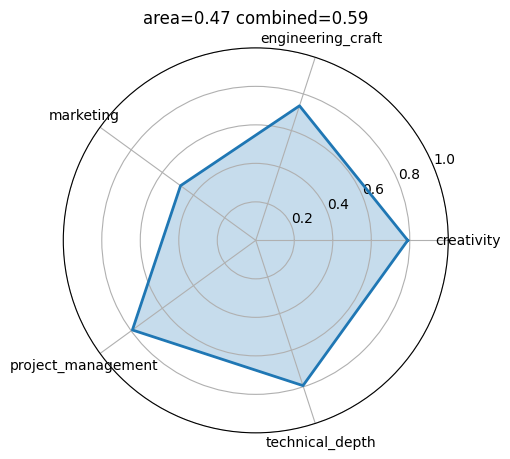

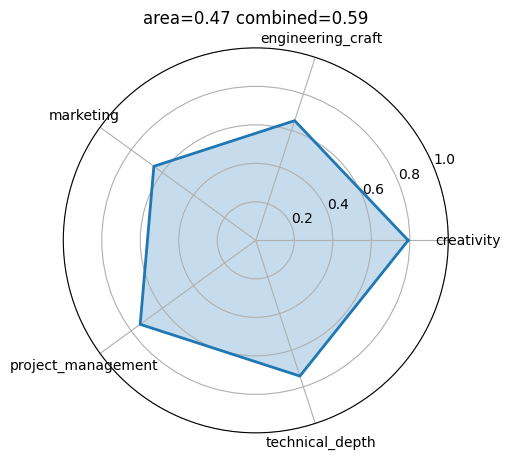

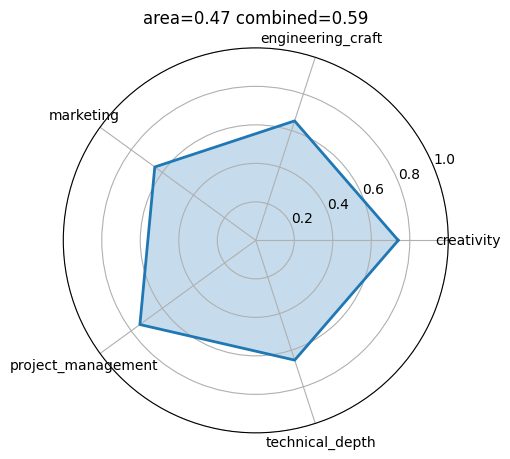

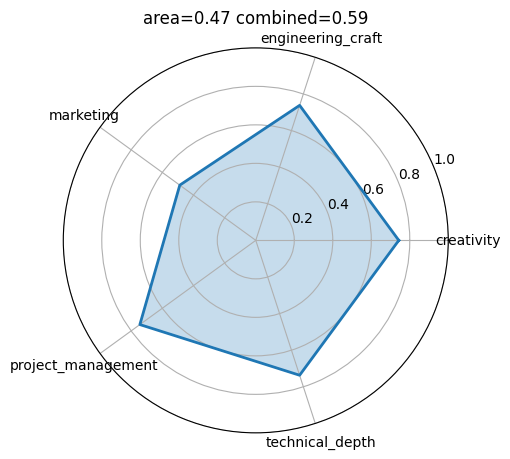

,group,members,area,area_frac,entropy_factor,weighted_combined
0,g4a,"(103952_Member_1.txt, 110020_Taowen...",1.223455,0.514567,0.895621,0.600859
1,g4b,"(112017_Ana Pitarch Arnau.txt, Meeting with Di...",1.221437,0.513718,0.790668,0.685332
3,g3b,"(Meeting with Bekhzod Ravshanov.txt, Meeting w...",1.125339,0.473301,0.919831,0.588916
2,g3a,"(114345_Alice Borsellino.txt, Meeting with Ann...",1.121864,0.471839,0.818596,0.668154


In [39]:
# Visualize coverage per group with radar (spiderweb) and coverage area
label_order = labels  # preserve the global label ordering used in scoring

# Choose a partition to visualize (best by entropy-adjusted score)
#out of top 100, pick a random row as "best"
#set seed for reproducibility
rng = np.random.default_rng(20251120)
top_100 = scores_df.sort_values('overall_entropy_adjusted', ascending=False).head(100)
best_row = top_100.sample(n=1, random_state=rng).iloc[0]

chosen_groups = [best_row['g4a'], best_row['g4b'], best_row['g3a'], best_row['g3b']]
chosen_metrics = best_row['per_group_metrics']

rows = []
for group_name, group_ids, metrics in zip(['g4a', 'g4b', 'g3a', 'g3b'], chosen_groups, chosen_metrics):
    per_label = metrics['per_label']
    vals = {lab: per_label.get(lab, {}).get('weighted_score', 0.0) for lab in label_order}
    area, area_frac = polygon_area([vals[lab] for lab in label_order])
    rows.append({
        'group': group_name,
        'members': group_ids,
        'area': area,
        'area_frac': area_frac,
        'entropy_factor': metrics.get('entropy_factor', 1.0),
        'weighted_combined': metrics['weighted']['combined'],
    })
#    title = f"area={area_frac:.2f} combined={metrics['weighted']['combined']:.2f}"
    fig, ax = plot_radar(label_order, vals, title=title)
    plt.show()

radar_df = pd.DataFrame(rows).sort_values('area_frac', ascending=False)
radar_df


In [ ]:
best_row = scores_df.sort_values('overall_entropy_adjusted', ascending=False).iloc[0]

best_row
#print full output of this row
import json
print(json.dumps(best_row.to_dict(), indent=2, ensure_ascii=False))

In [ ]:
scores_df

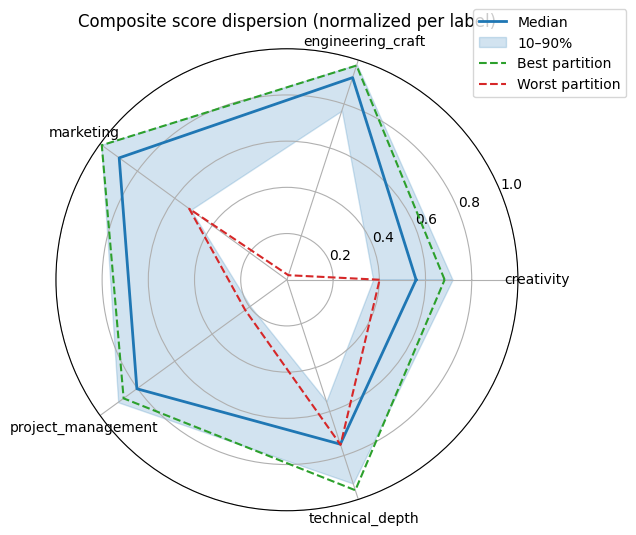

In [35]:
# Dispersion of per-label composite scores (normalized per label to [0,1])
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Choose which partitions to summarize (all by default; or e.g., top 500 by entropy-adjusted)
rows = scores_df
# rows = scores_df.nlargest(500, "overall_entropy_adjusted")

label_order = labels  # keep consistent ordering

# Collect per-label weighted scores per partition

def extract_partition_scores(row):
    metrics_list = row["per_group_metrics"]
    per_label_vals = {lab: [] for lab in label_order}
    for metrics in metrics_list:
        per_label = metrics["per_label"]
        for lab in label_order:
            per_label_vals[lab].append(per_label.get(lab, {}).get("weighted_score", 0.0))
    return np.array([np.mean(per_label_vals[lab]) for lab in label_order])

# Raw scores for selected rows
raw_label_scores = np.vstack(rows.apply(extract_partition_scores, axis=1))

# Min–max normalize each label to [0,1] within these rows
mins = raw_label_scores.min(axis=0)
maxs = raw_label_scores.max(axis=0)
denom = np.where(maxs > mins, maxs - mins, 1.0)
all_label_scores = np.clip((raw_label_scores - mins) / denom, 0, 1)

# Stats on normalized scores
median_vals = np.median(all_label_scores, axis=0)
q10_vals = np.percentile(all_label_scores, 10, axis=0)
q90_vals = np.percentile(all_label_scores, 90, axis=0)

# Best/worst normalized using the same mins/maxs
best_vals = np.clip((extract_partition_scores(scores_df.loc[scores_df["overall_entropy_adjusted"].idxmax()]) - mins) / denom, 0, 1)
worst_vals = np.clip((extract_partition_scores(scores_df.loc[scores_df["overall_entropy_adjusted"].idxmin()]) - mins) / denom, 0, 1)


def radar_plot_with_band(label_order, center_vals, lo_vals, hi_vals, refs=None, title="Dispersion radar"):
    angles = np.linspace(0, 2 * np.pi, len(label_order), endpoint=False)
    angles = np.concatenate([angles, angles[:1]])

    def close(vals):
        return np.concatenate([vals, vals[:1]])

    fig, ax = plt.subplots(subplot_kw={"polar": True}, figsize=(6, 6))
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(label_order)
    ax.set_ylim(0, 1)

    ax.plot(angles, close(center_vals), color="tab:blue", lw=2, label="Median")
    ax.fill_between(angles, close(lo_vals), close(hi_vals), color="tab:blue", alpha=0.2, label="10–90%")
    if refs:
        for name, vals, color in refs:
            ax.plot(angles, close(vals), color=color, lw=1.5, ls="--", label=name)

    ax.set_title(title)
    ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1))
    return fig, ax

radar_plot_with_band(
    label_order,
    center_vals=median_vals,
    lo_vals=q10_vals,
    hi_vals=q90_vals,
    refs=[
        ("Best partition", best_vals, "tab:green"),
        ("Worst partition", worst_vals, "tab:red"),
    ],
    title="Composite score dispersion (normalized per label)",
)
plt.show()
